## Регрессия на imdb

In [1]:
# ячейка импортов
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [2]:
# загрузка файла
from google.colab import files
uploaded = files.upload()

Saving IMDB-Movie-Data.csv to IMDB-Movie-Data.csv


In [3]:
data = pd.read_csv('IMDB-Movie-Data.csv')

data.head(3)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


## Регрессии:

В этом датасете для регрессии есть несколько опций, выбирайте то, что более интересно: 

- определить рейтинг по описанию фильма
- определить длительность фильма по году создания
- определить рейтинг по длине фильма
- Ваша идея

Шаги выполнения: 
- Определите, какие части датасета необходимы для вашей задачи
- Если работаете с текстовыми ячейками, векторизуйте тексты
- Разделите данные на обучающую и тестовую выборку
- Попробуйте обучить [разные регрессионные модели](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) (не забудьте импортировать их в эту тетрадку)

- Для каждой модели посмотрите на метрики. 

Какая/какие модель/ли справляются с выбранной Вами задачей наиболее эффективно?

Цель: определить длительность фильма по году создания, рейтингу и количеству голосов.

In [4]:
data.shape

(1000, 12)

In [5]:
data.rename({'Runtime (Minutes)':'Runtime'}, 
                    axis=1, inplace=True)

In [6]:
data.head(3)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime,Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


In [7]:
# метод corr считает корреляцию всех колонок со всеми
data.corr()

,Rank,Year,Runtime,Rating,Votes,Revenue (Millions),Metascore
Rank,1.000000,-0.261605,-0.221739,-0.219555,-0.283876,-0.271592,-0.191869
Year,-0.261605,1.000000,-0.164900,-0.211219,-0.411904,-0.126790,-0.079305
Runtime,-0.221739,-0.164900,1.000000,0.392214,0.407062,0.267953,0.211978
Rating,-0.219555,-0.211219,0.392214,1.000000,0.511537,0.217654,0.631897
Votes,-0.283876,-0.411904,0.407062,0.511537,1.000000,0.639661,0.325684
Revenue (Millions),-0.271592,-0.126790,0.267953,0.217654,0.639661,1.000000,0.142397
Metascore,-0.191869,-0.079305,0.211978,0.631897,0.325684,0.142397,1.000000


In [8]:
# проверка, что все поля заполнены и нулевых значений нет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime             1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


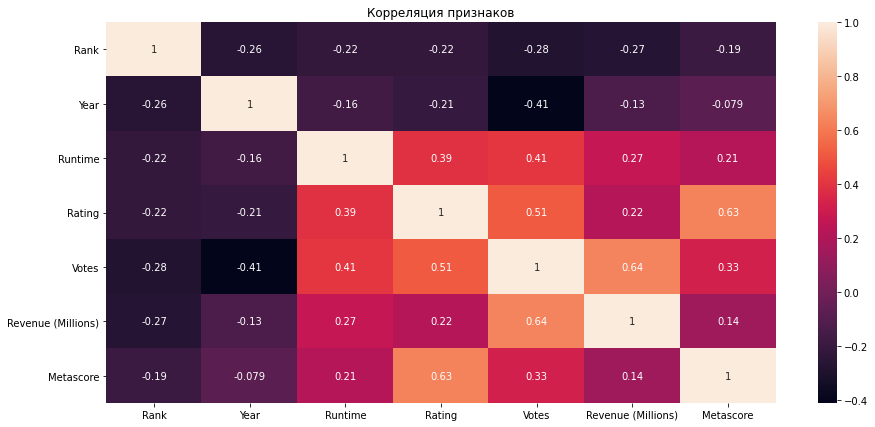

In [9]:
# красивое представление корреляции
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,7))

sns.heatmap(data=data.corr(), annot=True, cmap= "rocket") 

plt.title("Корреляция признаков") # подпись графика
plt.show()

In [10]:
data = data[['Year','Runtime', 'Rating', 'Votes']]

data.head(3)

,Year,Runtime,Rating,Votes
0,2014,121,8.1,757074
1,2012,124,7.0,485820
2,2016,117,7.3,157606


In [11]:
data2 = data.drop('Runtime', axis=1)
X = data2.values # выбросили из датафрейма информацию про длительность целевую переменную (длительность)

display(X, X.shape)

array([[2.01400e+03, 8.10000e+00, 7.57074e+05],
       [2.01200e+03, 7.00000e+00, 4.85820e+05],
       [2.01600e+03, 7.30000e+00, 1.57606e+05],
       ...,
       [2.00800e+03, 6.20000e+00, 7.06990e+04],
       [2.01400e+03, 5.60000e+00, 4.88100e+03],
       [2.01600e+03, 5.30000e+00, 1.24350e+04]])

(1000, 3)

In [12]:
y = data['Runtime'].values # отдельно вынесли массив со значениями целевой переменной (длительности)
display(y, y.shape)

array([121, 124, 117, 108, 123, 103, 128,  89, 141, 116, 133, 127, 133,
       107, 109,  87, 139, 123, 118, 116, 120, 137, 108,  92, 120,  83,
       159,  99, 100, 115, 111, 116, 144, 108, 107, 147, 169, 115, 132,
       113,  89, 111,  73, 115,  99, 136, 132,  91, 122, 130, 136,  91,
       118, 101, 152, 161,  88, 106, 117,  96, 151,  86, 112, 125, 130,
       129, 133, 120, 106, 107, 133, 124, 108,  97, 108, 169, 143, 153,
       151, 116, 148, 118, 180, 149, 137, 124, 129, 162, 187, 128, 153,
       123, 146, 114, 141, 116, 106,  90, 105, 151, 132, 115, 144, 106,
       116, 102, 120, 110, 105, 108,  89, 134, 118, 117, 130, 105, 118,
       161, 104,  97, 127, 139,  98,  86, 164, 106, 165,  96, 108, 156,
       139, 125,  86, 107, 130, 140, 122, 143, 138, 148, 127,  94, 130,
       118, 165, 144, 104, 162, 113, 121, 117, 142,  88, 121,  91,  94,
       131, 118, 112, 121, 106,  90, 132, 118, 144, 122, 129, 109, 144,
       148, 118, 101,  84, 126, 102, 130, 130, 107, 134, 117, 11

(1000,)

In [15]:
# делим датасет на части
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # создали переменные, разделили данные

Ridge

In [17]:
# силу регуляризации можно варьировать параметром alpha
regressor = Ridge(alpha=0.01) # 0.01 и 10  - не меняется результат.

regressor.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
list(zip(data2.columns, regressor.coef_)) # определили зависимость между целевой переменной и основными признаками

[('Year', 0.20205728484094948),
 ('Rating', 4.7228475514577),
 ('Votes', 3.163035554510612e-05)]

In [19]:
# Чтобы оценить качество модели, предскажем значения целевой переменной на тестовой выборке и сравним с настоящими значениями.
preds = regressor.predict(X_test)


Оценка результатов алгоритма

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [22]:
mean_absolute_error(y_test, preds)
# насколько наши данные отклонились от их настоящего значения.
# т.е. в среднем алгоритм ошибается на 13,6 минут

13.613648442295498

In [23]:
from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.18142534814514621

Lasso

In [24]:
regressor = Lasso(alpha=0.1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)


print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

13.614482932624968
0.18125636616381646


Итоги: я попробовала использовать модели Ridge и Lasso. 
В качестве метрики использовалась средняя абсолютная ошибка. Она показывает отклонение от правильного ответа в тех же единицах измерения. В обеих моделях алгоритм ошибается в среднем на 13,6 минут. R2 score также одинаковый (до тысячных). Таким образом, можно сделать вывод, что обе модели работают неэффективно и сложно назвать их применимыми для реальных задач. Предполагаю, что дело может быть в малой корреляции между переменными.
